# White light curve

In this notebook you learn how to estimate a white light curve and fit for the wavelength independent light curve parameters + nuisance parameters.

The dataset used is the preprocessed timelines from the JWST observation of one transit of WASP 39b:

The dataset used corresponds to one transit of WASP-39b observed with the NIRSpec PRISM mode, with the 8.23-h observation roughly centred around the transit event. The NIRSpec’s Bright Object Time Series (BOTS) mode with the NRSRAPID readout pattern, the S1600A1 slit (1.6" × 1.6" ) and the SUB512 subarray are used.

The observation, timeline, data analysis and data availablilty are discussed by [Rustamkulov et al. (2023)](https://www.nature.com/articles/s41586-022-05677-y).

The white light curve fitting and the motivation are discussed by Rustamkulov et al. (2023) in their *method* section.



In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit
import sys, os, pickle, copy
from google.colab import drive

out = drive.mount('/content/drive', force_remount=True)
PYTHONLIB = "/content/drive/Shareddrives/planets_and_exoplanets/pythonlib"
try:
  sys.path.remove(PYTHONLIB)
except ValueError:
  pass

sys.path.insert(1, PYTHONLIB)

import emcee
import corner
import batman

Mounted at /content/drive


# Initial parameters

We make use of "batman" for lighcurve modelling and fitting.

We assum a planet on a circular orbit (e=0, $\omega = 90^o$) and orbital period from Kokori et al. (2023).

Free parameters are t0, rp, a, inc and u, repectiveluy the time at mid-transit, the radius of the planet in units of stelar radii, the semimajor axis in units of stellar radii, the orbital inclination and the two quadratic lib darkening coefficients. Free parameters are initialised to the values estimated by Kokori et al. (2023).

Transit duration (T14) is estimated and will be used later in the notebook to mask the location of the transit.

In [2]:
params = batman.TransitParams()

# Kokori 2023
params.t0 = 0.                       #time of inferior conjunction
params.per = 4.05528043*24           #orbital period (hr)
params.rp = 0.1457                   #planet radius (in units of stellar radii)
params.a = 11.37                     #semi-major axis (in units of stellar radii)
params.inc = 87.75                   #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.4,0.2]                     #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening modelrp_over_rs  = 0.12086

def impactb(params):
  w = np.deg2rad(params.w)
  inc = np.deg2rad(params.inc)
  retval = (1-params.ecc**2)/(1+params.ecc*np.sin(w))
  retval *= params.a*np.cos(inc)

  return retval

def transit_duration(params):
  # Calculates transit durations (T14) assuming
  # a circular orbit (params.ecc = 0)
  b = impactb(params)
  if b > 1: b = 0.5
  arg = np.sqrt( (1+params.rp)**2 - b**2 ) / params.a
  retval = np.arcsin(arg) * 2*params.per/(2*np.pi)

  return retval


T14 = transit_duration(params)
print('Transit duration {:.2f} hr'.format(T14))

Transit duration 2.88 hr


# Preprocessed data

Preprocessed data are loaded. It is a 3D datacube containing lightcurves vs wavelnght and vs time and associated random uncertainities.

The prprocessing follows that described by Rustamkulov et al. (2023) and it is not discussed here. The uncertainities are an estimate of photon shot noise and detector readout noise. Any systematic uncertainty is not accounted for.

In [3]:
file_name = '/content/drive/Shareddrives/planets_and_exoplanets/Data/jwst01366004001-wasp39b-lightcurves.pkl'
with open(file_name, 'rb') as file_stream:
  data = pickle.load(file_stream)

tt = data['time'] # time in units of hours
wl = data['wavelength'] # wavelength in microns
slc = data['lc']  # spectal lightcurves in counts
Eslc = data['Elc'] # Random error in counts

mask = tt > -4
slc  = slc[mask,...]
Eslc  = Eslc[mask,...]
tt = tt[mask]

27

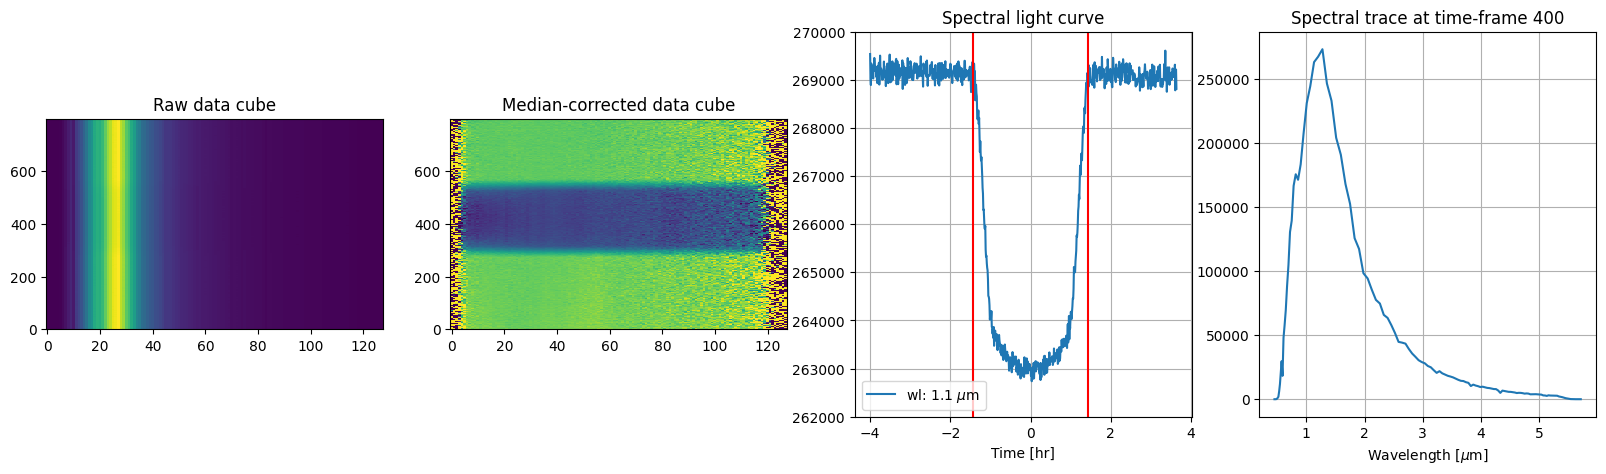

In [4]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(20, 5))
ax0.imshow(slc, aspect=0.1, interpolation='None', origin='lower')
ax0.set_title('Raw data cube')

norm = np.ma.median(slc, axis=0)
ax1.imshow(slc/norm, aspect=0.1, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')
ax1.set_title('Median-corrected data cube')

ax2.plot(tt, slc[:, 25], label = 'wl: {:.1f} $\mu$m'.format(wl[25]))
ax2.set_xlabel('Time [hr]')
ax2.vlines([-T14/2, T14/2], 262000, 270000, 'r')
ax2.grid()
ax2.legend()
ax2.set_title('Spectral light curve')
ax2.set_ylim(262000, 270000)

ax3.plot(wl, slc[400, :])
ax3.set_xlabel('Wavelength [$\mu$m]')
ax3.grid()
ax3.set_title('Spectral trace at time-frame 400')
np.argmax(slc[400, :])

# Baseline correction

Mask the transit and fit a line to each spectral lightcurve bin. Dived-out the model line and propagate the statistical uncertainty using the error propagation equation.

In [5]:
mask = np.logical_or(tt<-1.05*T14/2, tt>1.05*T14/2)
slc_new = slc.copy()
Eslc_new = Eslc.copy()
for idx in range(slc.shape[1]):
  p = np.polyfit(tt[mask], slc[mask, idx], 2)
  baseline = np.poly1d(p)
  slc_new[:, idx] /= baseline(tt)
  Eslc_new[:, idx] /= baseline(tt)

Text(0.5, 1.0, 'Normalised spectral lightcurve')

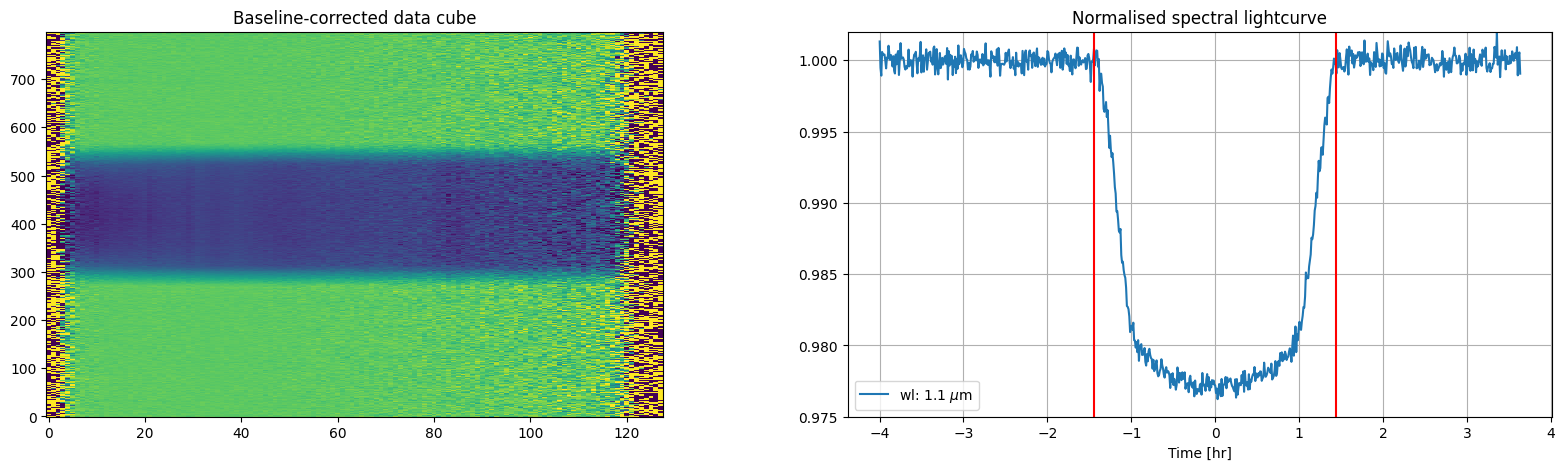

In [6]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20, 5))


ax0.imshow(slc_new, aspect=0.1, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')
ax0.set_title('Baseline-corrected data cube')
ax1.plot(tt, slc_new[:, 25], label = 'wl: {:.1f} $\mu$m'.format(wl[25]))
ax1.set_xlabel('Time [hr]')
ax1.legend()
ax1.vlines([-T14/2, T14/2], 0.975, 1.002, 'r')
ax1.set_ylim(0.975, 1.002)
ax1.grid()
ax1.set_title('Normalised spectral lightcurve')

# White lightcurve estimate

Estimate white lighcurve implementing a weighted averaged signal vs time.

The weights used are the inverse random uncertaintis squared, averaged over time to avoid polluting the signal with outliers in the noise vectors.

Statistical uncertainties are propagated accordingly.

In [7]:
weight = 1/Eslc_new.sum(axis=0)**2
wlc = np.ma.sum(slc_new*weight, axis=1)/np.ma.sum(weight)
Var = np.ma.sum(Eslc_new**2 * weight**2, axis=1)/np.ma.sum(weight)**2
Ewlc = np.sqrt(Var)

Text(0.5, 1.0, 'Normalised lightcurves')

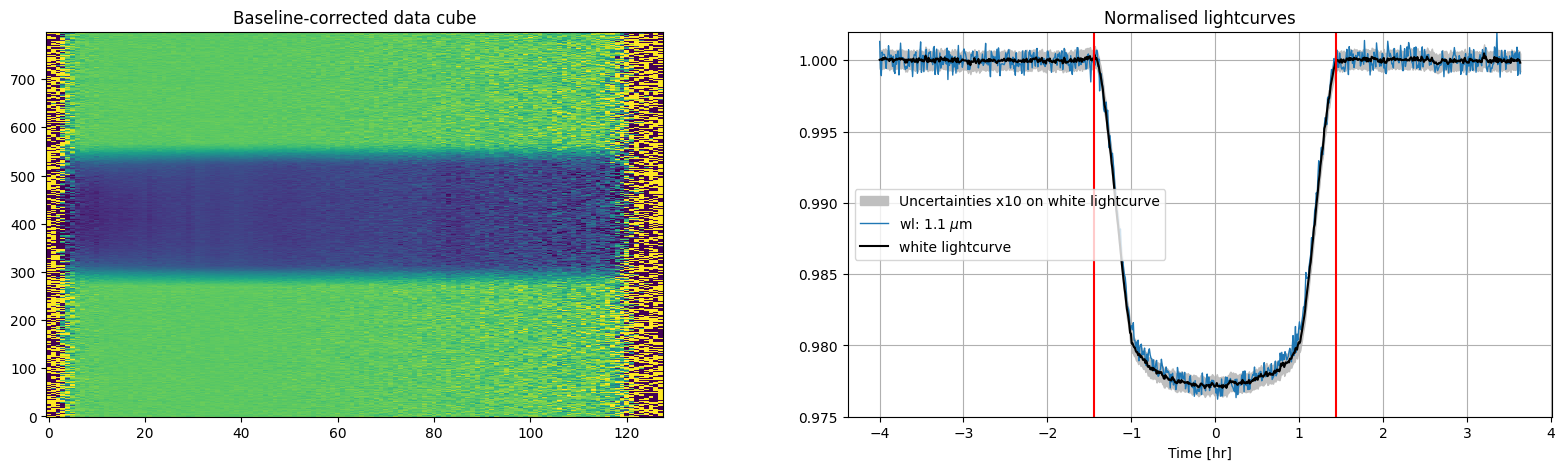

In [8]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20, 5))

ax0.imshow(slc_new, aspect=0.1, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')
ax0.set_title('Baseline-corrected data cube')

ax1.fill_between(tt, wlc-1e1*Ewlc, wlc+1e1*Ewlc, color='0.75', alpha = 1, label = 'Uncertainties x10 on white lightcurve')
ax1.plot(tt, slc_new[:, 25], alpha = 1, lw = 1, label = 'wl: {:.1f} $\mu$m'.format(wl[25]))
ax1.plot(tt, wlc, 'k', label='white lightcurve')

ax1.set_xlabel('Time [hr]')
ax1.vlines([-T14/2, T14/2], 0.975, 1.002, 'r')
ax1.set_ylim(0.975, 1.002)
#ax1.set_ylim(0.998, 1.002)

ax1.grid()
ax1.legend()
ax1.set_title('Normalised lightcurves')

In [35]:
#@title Model class
# @markdown This is our usal model class, implementing a batman transit model.
#
class Model:
  """
    Model definition

    Parameters
    ----------
    par : array
        Model parameters

    Returns
    -------
    out : an instance of Model
  """

  __model__ = None

  def __init__(self, time, params):
    self.__params__ = copy.deepcopy(params)
    self.__model__ = batman.TransitModel(self.__params__, time)

  def __call__(self, x, *par):
    """
      Parameters
      ----------
      x : array
        the model independent variable
      par : array
        evaluates model on the new parameter set

      Returns
      -------
      out : array
        the model evaluated at x
    """
    self.__params__.t0, \
    self.__params__.rp, \
    self.__params__.a, \
    self.__params__.inc, \
    self.__params__.u[0], \
    self.__params__.u[1], \
    a, b, \
    *not_used = par

    baseline = np.poly1d([a, b])
    tlc = self.__model__.light_curve(self.__params__)

    return tlc/baseline(x)

  def chi2(self, par, x, y, yerr):
    """
      Chi2 estimator

      Parameters
      ----------
      par : array
        model parametrs
      x : array
        independent variable
      y : array
        observations
      yerr : array
        uncertainties on the observations y

      Returns
      -------
      out : scalar
        Chi2
    """
    mu = self.__call__(x, *par)
    local_chi2 = np.sum( ((y-mu)/yerr)**2 )
    return local_chi2

  def ln_likelihood(self, par, x, y, yerr):
    return -0.5*self.chi2(par, x, y, yerr) -np.log(yerr).sum()

  def ln_prior(self, par):
    # add your priors here
    if par[1] < 0.0 or par[1]>1: return -np.inf      # rp
    if par[2] < 0.0:             return -np.inf      # a
    if par[3] < 0.0 or par[3]> 90.0: return -np.inf      # u0
    if par[4] < 0.0 or par[4]>1: return -np.inf      # u0
    if par[5] < 0.0 or par[5]>1: return -np.inf      # u1

    return 0.0

  def ln_prob(self, par, x, y, yerr):

    ln_prior = self.ln_prior(par)
    if not np.isfinite(ln_prior):
      return -np.inf

    ln_likelihood = self.ln_likelihood(par, x, y, yerr)

    return ln_likelihood + ln_prior

# Model instantiation

Below, the model is instantiated and validated.

Text(0.5, 1.0, 'Normalised lightcurves')

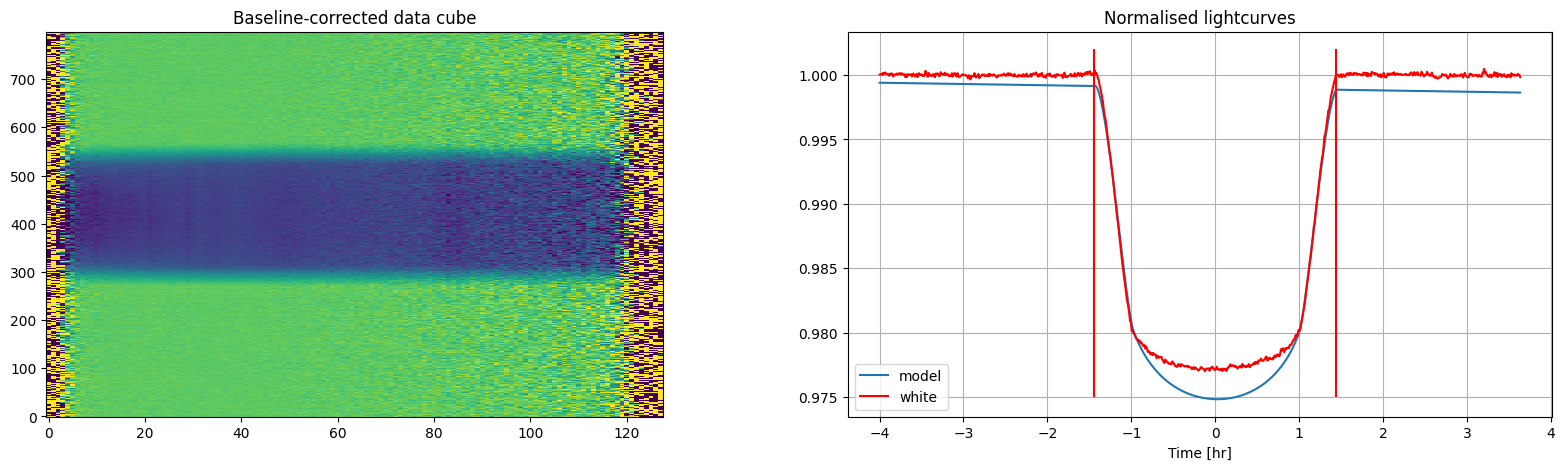

In [60]:
model = Model(tt, params)

par0 = params.t0, params.rp, params.a, params.inc, params.u[0], params.u[1], 1e-4, 1.001

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(20, 5))

ax0.imshow(slc_new, aspect=0.1, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')
ax0.set_title('Baseline-corrected data cube')
ax1.plot(tt, model(tt, *par0), label='model')
ax1.plot(tt, wlc, 'r', label='white')
ax1.set_xlabel('Time [hr]')
ax1.vlines([-T14/2, T14/2], 0.975, 1.002, 'r')
#ax1.set_ylim(0.975, 1.002)
ax1.grid()
ax1.legend()
ax1.set_title('Normalised lightcurves')

# What do to next

Follow the eample of "LAB05 - RV model fit" and

1. Implement a MLE parameter estimation.
  - plot data and model MLE
  - compare Kokori et al. (2023) parameters with MLE and theirs uncertaities
2. Implement a emcee to estimate the wlc parameters and compare your results (medians and confidence levels) with Table 1 of Rustamkulov et al. (2023).



Input parameters: t0: 0.0121, rp:   0.1453, a: 11.447, i: 87.81, u0: 0.40, u1:  0.20, m:  1.00e-04 q: 1.00e+00
MLE:              t0: 0.0121, rp:   0.1453, a: 11.447, i: 87.81, u0: 0.14, u1:  0.27, m:  1.99e-07 q: 1.00e+00
Uncertainties:    t0: 0.0001, rp: 7.36e-05, a: 0.0100, i: 0.01, u0: 0.01, u1:  0.02, m:  1.03e-06 q: 2.83e-06
Chi2:             2545, dof: 791


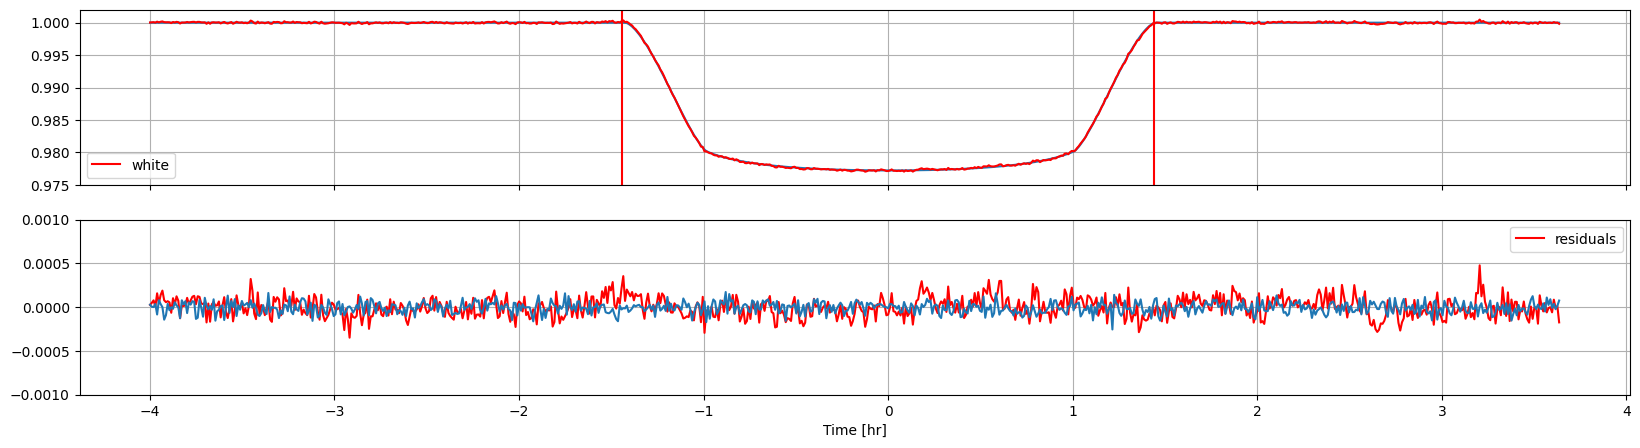

In [61]:
parMLE, coVar = curve_fit(model,  tt, wlc, sigma=Ewlc,
                          p0 = par0,
                          absolute_sigma = True,
                        )

pErr = np.sqrt(np.diag(coVar))

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20, 5), sharex=True)

ax0.plot(tt, model(tt, *parMLE))
ax0.plot(tt, wlc, 'r', label='white')
ax0.vlines([-T14/2, T14/2], 0.975, 1.002, 'r')
ax0.set_ylim(0.975, 1.002)
ax0.grid()
ax0.legend()


ax1.plot(tt, wlc-model(tt, *parMLE), 'r', label='residuals')
ax1.plot(tt, np.random.randn(Ewlc.size)*Ewlc)
ax1.vlines([-T14/2, T14/2], 0.975, 1.002, 'r')
ax1.set_ylim(-1e-3, 1e-3)
ax1.grid()
ax1.legend()
ax1.set_xlabel('Time [hr]')


chi2 = model.chi2(parMLE, tt, wlc, Ewlc)
dof = wlc.size - len(parMLE)

params.t0 = parMLE[0]                   #time of inferior conjunction
params.rp = parMLE[1]                   #planet radius (in units of stellar radii)
params.a = parMLE[2]                    #semi-major axis (in units of stellar radii)
params.inc = parMLE[3]                  #orbital inclination (in degrees)

print('Input parameters: t0: {:.4f}, rp: {:8.4f}, a: {:6.3f}, i: {:.2f}, u0: {:.2f}, u1: {:5.2f}, m: {:9.2e} q: {:8.2e}'.format(*par0))
print('MLE:              t0: {:.4f}, rp: {:8.4f}, a: {:6.3f}, i: {:.2f}, u0: {:.2f}, u1: {:5.2f}, m: {:9.2e} q: {:8.2e}'.format(*parMLE))
print('Uncertainties:    t0: {:.4f}, rp: {:8.2e}, a: {:6.4f}, i: {:.2f}, u0: {:.2f}, u1: {:5.2f}, m: {:9.2e} q: {:8.2e}'.format(*pErr))
print('Chi2:             {:.0f}, dof: {:d}'.format(chi2, dof ) )

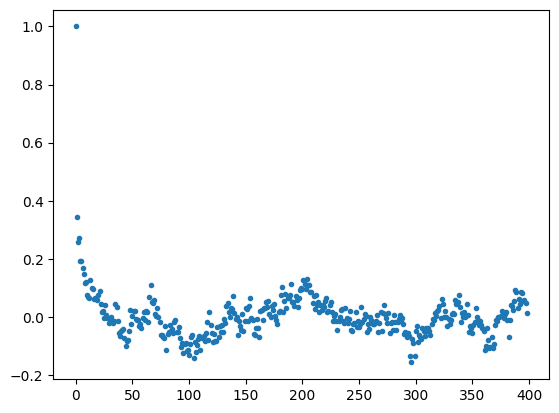

In [79]:
y = wlc-model(tt, *parMLE)
norm = np.mean(y*y)
c = []
for k in range(0, wlc.size//2):
  y_ = np.roll(y, k)
  c.append(np.mean( y*y_ )/norm)

plt.plot(c, '.')

In [38]:
class SpectralModel(Model):
  def __call__(self, x, *par):
    """
      Parameters
      ----------
      x : array
        the model independent variable
      par : array
        evaluates model on the new parameter set

      Returns
      -------
      out : array
        the model evaluated at x
    """
    self.__params__.rp, \
    self.__params__.u[0], \
    self.__params__.u[1], \
    a, b, \
    *not_used = par

    baseline = np.poly1d([a, b])
    tlc = self.__model__.light_curve(self.__params__)

    return tlc/baseline(x)

  def ln_prior(self, par):
    # add your priors here
    if par[1] < 0.0 or par[1]>1: return -np.inf      # rp
    if par[2] < 0.0 or par[2]> 90.0: return -np.inf      # u0
    if par[3] < 0.0 or par[3]>1: return -np.inf      # u0

    return 0.0

In [39]:
spec  = np.zeros_like(wl)
Espec = np.zeros_like(wl)
chi2  = np.zeros_like(wl)

for k in range(wl.size):
  smodel = SpectralModel(tt, params)
  par0 = params.rp, params.u[0], params.u[1], 0.0, 1.0

  try:
    parMLE, coVar = curve_fit(smodel,  tt, slc_new[:, k], sigma=Eslc_new[:, k],
                            p0 = par0,
                            absolute_sigma = True,
                          )
    spec[k] = parMLE[0]
    Espec[k] = np.sqrt(coVar[0,0])

    dof = slc_new[:, k].size - len(parMLE)
    chi2[k] = smodel.chi2(parMLE, tt, slc_new[:, k], Eslc_new[:, k])/dof

  except:
    spec[k] = np.nan
    Espec[k] = np.nan

spec2 = 100*spec**2
Espec2 = 100*2*np.abs(spec)*Espec

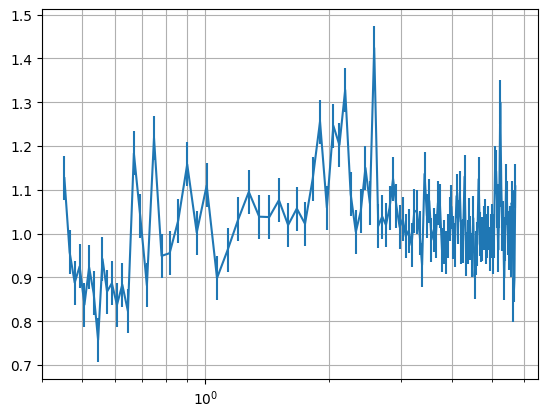

In [45]:
plt.errorbar(wl, chi2, yerr=np.ones_like(wl)*np.sqrt(2/dof))
plt.grid(which='both')
plt.xscale("log")

In [18]:
fname = "/content/drive/Shareddrives/planets_and_exoplanets/Data/WASP-39b-FIREFLy.csv"

FIREFLy = np.loadtxt(fname, delimiter=',')

Text(0, 0.5, '$(R_p/R_*)^2$')

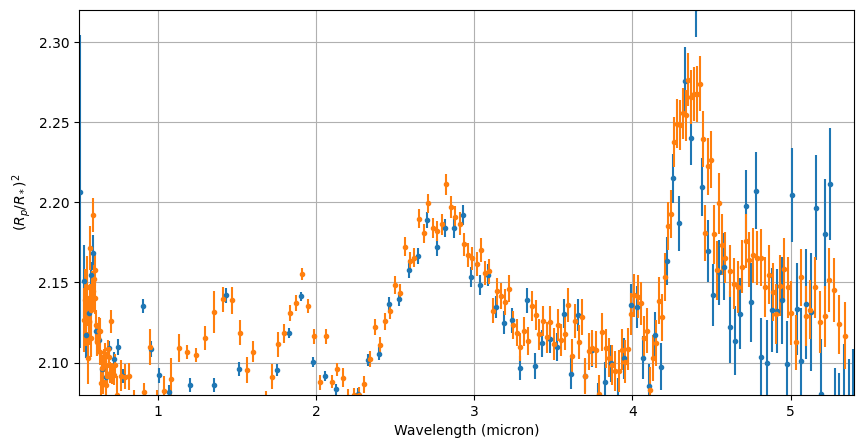

In [29]:
fig, ax0 = plt.subplots(1,1, figsize=(10,5))


ax0.errorbar(wl, spec2, yerr=Espec2, fmt='.')
ax0.errorbar(FIREFLy[:, 0], 100*FIREFLy[:, 1], yerr=100*FIREFLy[:, 2], fmt='.')

ax0.set_xlim(0.5, 5.4)
ax0.set_ylim(2.08, 2.32)
ax0.grid()
ax0.set_xlabel('Wavelength (micron)')
ax0.set_ylabel('$(R_p/R_*)^2$')
#ax0.set_xscale("log")


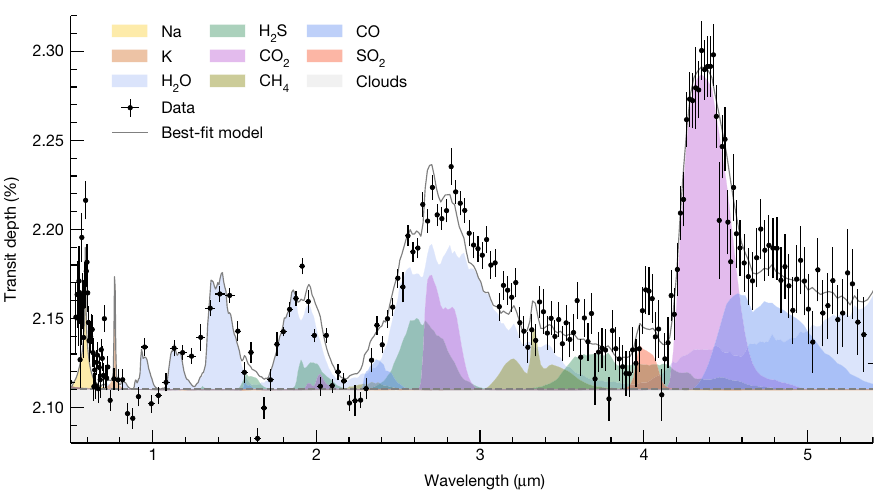